In [123]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [124]:
data = pd.read_csv('../resources/data/cardio/cardio_train.csv', sep=';')

### Cardiovascular Disease dataset
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

In [125]:
print(data.shape)
print(1. * np.sum(data['cardio']) / data.shape[0])

(70000, 13)
0.4997


In [126]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


### Train a feed forward network

In [127]:
ordinal = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
target = 'cardio'
X, y = data[ordinal + categorical], data[target]

In [128]:
from sklearn.model_selection import train_test_split

# val dataset in GridSearchCV
train_ratio, test_ratio, target_ratio = .8, .1, .1

test_and_target = test_ratio + target_ratio
op_train_ratio = 1. - train_ratio

X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, test_size=op_train_ratio)
X_test, X_target, y_test, y_target = train_test_split(X_heldout, y_heldout, test_size=target_ratio / test_and_target)

# to check if this stuff works correctly :)
# to_check = data['id']
# to_check_train, to_check_heldout = train_test_split(to_check, test_size=op_train_ratio)
# to_check_val, to_check_tmp = train_test_split(to_check_heldout, test_size=test_and_target / op_train_ratio)
# to_check_test, to_check_target = train_test_split(to_check_tmp, test_size=target_ratio / test_and_target)
# check = np.concatenate([to_check_train, to_check_test, to_check_val, to_check_target])
# print(check.shape[0] == np.unique(check).shape[0])

### GridSearch + Pipeline + keras feed-forward NN

In [129]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaled_numeric', StandardScaler(), ordinal)
])

def create_model(size_1, size_2):
    nn = keras.Sequential([
        keras.layers.Dense(size_1, activation=tf.nn.relu),
        keras.layers.Dense(size_2, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    nn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return nn

model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)

pipeline = Pipeline([('transformers', feature_transformation), ('estimator', model)])

params = {
    'estimator__epochs': [50],
    'estimator__batch_size': [1024],
    'estimator__size_1': [4, 8, 16],
    'estimator__size_2': [4, 8]
}

clf = GridSearchCV(pipeline, params, cv=5, verbose=1)
# n_jobs=-1
clf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
44800/44800 [==============================] - 2s 35us/step - loss: 0.7113 - acc: 0.5123
Epoch 2/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6823 - acc: 0.5718
Epoch 3/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6759 - acc: 0.5994
Epoch 4/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6705 - acc: 0.6118
Epoch 5/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6646 - acc: 0.6224
Epoch 6/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6585 - acc: 0.6319
Epoch 7/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6526 - acc: 0.6404
Epoch 8/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6470 - acc: 0.6472
Epoch 9/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6418 - acc: 0.6508
Epoch 10/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6371 - acc: 0.6549
Epoch 11

44800/44800 [==============================] - 0s 3us/step - loss: 0.5573 - acc: 0.7299
Epoch 32/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5571 - acc: 0.7301
Epoch 33/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5568 - acc: 0.7298
Epoch 34/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5565 - acc: 0.7298
Epoch 35/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5564 - acc: 0.7303
Epoch 36/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5565 - acc: 0.7302
Epoch 37/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5559 - acc: 0.7306
Epoch 38/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5558 - acc: 0.7300
Epoch 39/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5555 - acc: 0.7301
Epoch 40/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5554 - acc: 0.7305
Epoch 41/50


44800/44800 [==============================] - 0s 2us/step - loss: 0.5969 - acc: 0.6867
Epoch 11/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5921 - acc: 0.6936
Epoch 12/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5875 - acc: 0.6979
Epoch 13/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5830 - acc: 0.7049
Epoch 14/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5790 - acc: 0.7086
Epoch 15/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5752 - acc: 0.7125
Epoch 16/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5714 - acc: 0.7169
Epoch 17/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5682 - acc: 0.7191
Epoch 18/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5657 - acc: 0.7212
Epoch 19/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5634 - acc: 0.7238
Epoch 20/50


44800/44800 [==============================] - 0s 4us/step - loss: 0.5520 - acc: 0.7322
Epoch 41/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.5516 - acc: 0.7313
Epoch 42/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5512 - acc: 0.7325
Epoch 43/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5511 - acc: 0.7317
Epoch 44/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5504 - acc: 0.7326
Epoch 45/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5502 - acc: 0.7319
Epoch 46/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5500 - acc: 0.7325
Epoch 47/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5498 - acc: 0.7320
Epoch 48/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5495 - acc: 0.7319
Epoch 49/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5494 - acc: 0.7319
Epoch 50/50


44800/44800 [==============================] - 0s 1us/step - loss: 0.6069 - acc: 0.6717
Epoch 20/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.6038 - acc: 0.6750
Epoch 21/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.6004 - acc: 0.6790
Epoch 22/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5966 - acc: 0.6836
Epoch 23/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5926 - acc: 0.6893
Epoch 24/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5884 - acc: 0.6946
Epoch 25/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5839 - acc: 0.7003
Epoch 26/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5797 - acc: 0.7032
Epoch 27/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5759 - acc: 0.7097
Epoch 28/50
44800/44800 [==============================] - 0s 1us/step - loss: 0.5722 - acc: 0.7129
Epoch 29/50


44800/44800 [==============================] - 0s 1us/step - loss: 0.5561 - acc: 0.7302
Epoch 50/50
44800/44800 [==============================] - 0s 1us/step
Epoch 1/50
44800/44800 [==============================] - 1s 31us/step - loss: 0.7282 - acc: 0.4832
Epoch 2/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6920 - acc: 0.5252
Epoch 3/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6707 - acc: 0.6020
Epoch 4/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6519 - acc: 0.6275
Epoch 5/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6403 - acc: 0.6375
Epoch 6/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6336 - acc: 0.6427
Epoch 7/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6299 - acc: 0.6462
Epoch 8/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.6275 - acc: 0.6482
Epoch 9/50
44800/44800 [========================

44800/44800 [==============================] - 0s 3us/step - loss: 0.5567 - acc: 0.7285
Epoch 29/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5560 - acc: 0.7288
Epoch 30/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5555 - acc: 0.7285
Epoch 31/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.5552 - acc: 0.7288
Epoch 32/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5549 - acc: 0.7292
Epoch 33/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5545 - acc: 0.7293
Epoch 34/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5540 - acc: 0.7293
Epoch 35/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5538 - acc: 0.7296
Epoch 36/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5534 - acc: 0.7299
Epoch 37/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5531 - acc: 0.7289
Epoch 38/50


44800/44800 [==============================] - 0s 2us/step - loss: 0.6069 - acc: 0.6727
Epoch 8/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5990 - acc: 0.6835
Epoch 9/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5904 - acc: 0.6947
Epoch 10/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5825 - acc: 0.7046
Epoch 11/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5753 - acc: 0.7118
Epoch 12/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5695 - acc: 0.7189
Epoch 13/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5655 - acc: 0.7227
Epoch 14/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5625 - acc: 0.7249
Epoch 15/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5605 - acc: 0.7272
Epoch 16/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5589 - acc: 0.7272
Epoch 17/50
44

Epoch 38/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5550 - acc: 0.7296
Epoch 39/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5547 - acc: 0.7313
Epoch 40/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5548 - acc: 0.7299
Epoch 41/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5543 - acc: 0.7300
Epoch 42/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5539 - acc: 0.7301
Epoch 43/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5534 - acc: 0.7303
Epoch 44/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5533 - acc: 0.7302
Epoch 45/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5529 - acc: 0.7310
Epoch 46/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5525 - acc: 0.7315
Epoch 47/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5521 - acc: 0.7305


44800/44800 [==============================] - 0s 3us/step - loss: 0.5678 - acc: 0.7202
Epoch 18/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5649 - acc: 0.7231
Epoch 19/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5631 - acc: 0.7252
Epoch 20/50
44800/44800 [==============================] - 0s 2us/step - loss: 0.5620 - acc: 0.7257
Epoch 21/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5604 - acc: 0.7272
Epoch 22/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5596 - acc: 0.7281
Epoch 23/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5591 - acc: 0.7283
Epoch 24/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5586 - acc: 0.7282
Epoch 25/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5583 - acc: 0.7284
Epoch 26/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5580 - acc: 0.7295
Epoch 27/50


44800/44800 [==============================] - 0s 5us/step - loss: 0.5490 - acc: 0.7341
Epoch 48/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5489 - acc: 0.7342
Epoch 49/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.5487 - acc: 0.7334
Epoch 50/50
44800/44800 [==============================] - 0s 2us/step
Epoch 1/50
44800/44800 [==============================] - 3s 68us/step - loss: 0.6784 - acc: 0.5560
Epoch 2/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6603 - acc: 0.6192
Epoch 3/50
44800/44800 [==============================] - 0s 6us/step - loss: 0.6445 - acc: 0.6327
Epoch 4/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.6347 - acc: 0.6408
Epoch 5/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.6287 - acc: 0.6460
Epoch 6/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.6239 - acc: 0.6516
Epoch 7/50
44800/44800 [======================

44800/44800 [==============================] - 0s 3us/step - loss: 0.5532 - acc: 0.7312
Epoch 27/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5525 - acc: 0.7326
Epoch 28/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5523 - acc: 0.7318
Epoch 29/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5518 - acc: 0.7314
Epoch 30/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5515 - acc: 0.7326
Epoch 31/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5511 - acc: 0.7326
Epoch 32/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5508 - acc: 0.7331
Epoch 33/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5506 - acc: 0.7322
Epoch 34/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5505 - acc: 0.7326
Epoch 35/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5501 - acc: 0.7328
Epoch 36/50


44800/44800 [==============================] - 0s 3us/step - loss: 0.6224 - acc: 0.6527
Epoch 6/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6145 - acc: 0.6627
Epoch 7/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6048 - acc: 0.6734
Epoch 8/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5936 - acc: 0.6881
Epoch 9/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5828 - acc: 0.7007
Epoch 10/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5736 - acc: 0.7123
Epoch 11/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5674 - acc: 0.7188
Epoch 12/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5633 - acc: 0.7227
Epoch 13/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5608 - acc: 0.7252
Epoch 14/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5589 - acc: 0.7262
Epoch 15/50
4480

Epoch 36/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5478 - acc: 0.7339
Epoch 37/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5474 - acc: 0.7345
Epoch 38/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5471 - acc: 0.7339
Epoch 39/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5466 - acc: 0.7349
Epoch 40/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5464 - acc: 0.7342
Epoch 41/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5464 - acc: 0.7338
Epoch 42/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5462 - acc: 0.7344
Epoch 43/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5458 - acc: 0.7350
Epoch 44/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5457 - acc: 0.7348
Epoch 45/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5452 - acc: 0.7357


44800/44800 [==============================] - 0s 3us/step - loss: 0.5627 - acc: 0.7265
Epoch 16/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5615 - acc: 0.7273
Epoch 17/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5614 - acc: 0.7267
Epoch 18/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5606 - acc: 0.7276
Epoch 19/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5604 - acc: 0.7280
Epoch 20/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5600 - acc: 0.7284
Epoch 21/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5592 - acc: 0.7290
Epoch 22/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5594 - acc: 0.7282
Epoch 23/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5588 - acc: 0.7290
Epoch 24/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5587 - acc: 0.7286
Epoch 25/50


44800/44800 [==============================] - 0s 5us/step - loss: 0.5489 - acc: 0.7336
Epoch 46/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5483 - acc: 0.7338
Epoch 47/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.5478 - acc: 0.7335
Epoch 48/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5477 - acc: 0.7339
Epoch 49/50
44800/44800 [==============================] - 0s 5us/step - loss: 0.5469 - acc: 0.7345
Epoch 50/50
44800/44800 [==============================] - 0s 2us/step
Epoch 1/50
44800/44800 [==============================] - 3s 70us/step - loss: 0.6806 - acc: 0.5625
Epoch 2/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6421 - acc: 0.6332
Epoch 3/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6192 - acc: 0.6564
Epoch 4/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6062 - acc: 0.6709
Epoch 5/50
44800/44800 [====================

44800/44800 [==============================] - 0s 3us/step - loss: 0.5560 - acc: 0.7308
Epoch 25/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5551 - acc: 0.7323
Epoch 26/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5542 - acc: 0.7320
Epoch 27/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5535 - acc: 0.7332
Epoch 28/50
44800/44800 [==============================] - 0s 4us/step - loss: 0.5530 - acc: 0.7320
Epoch 29/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5522 - acc: 0.7330
Epoch 30/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5513 - acc: 0.7325
Epoch 31/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5506 - acc: 0.7342
Epoch 32/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5498 - acc: 0.7331
Epoch 33/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5492 - acc: 0.7336
Epoch 34/50


44800/44800 [==============================] - 0s 3us/step - loss: 0.6244 - acc: 0.6526
Epoch 4/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6146 - acc: 0.6633
Epoch 5/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.6056 - acc: 0.6731
Epoch 6/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5966 - acc: 0.6847
Epoch 7/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5876 - acc: 0.6960
Epoch 8/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5795 - acc: 0.7071
Epoch 9/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5728 - acc: 0.7148
Epoch 10/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5681 - acc: 0.7205
Epoch 11/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5656 - acc: 0.7229
Epoch 12/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5636 - acc: 0.7262
Epoch 13/50
44800/

Epoch 34/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5454 - acc: 0.7357
Epoch 35/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5448 - acc: 0.7353
Epoch 36/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5446 - acc: 0.7353
Epoch 37/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5442 - acc: 0.7358
Epoch 38/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5442 - acc: 0.7364
Epoch 39/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5439 - acc: 0.7359
Epoch 40/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5436 - acc: 0.7361
Epoch 41/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5436 - acc: 0.7356
Epoch 42/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5435 - acc: 0.7362
Epoch 43/50
44800/44800 [==============================] - 0s 3us/step - loss: 0.5432 - acc: 0.7361


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.7min finished


Epoch 1/50
56000/56000 [==============================] - 3s 59us/step - loss: 0.6639 - acc: 0.6070
Epoch 2/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.6295 - acc: 0.6495
Epoch 3/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.6170 - acc: 0.6619
Epoch 4/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.6055 - acc: 0.6741
Epoch 5/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5924 - acc: 0.6893
Epoch 6/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5811 - acc: 0.7046
Epoch 7/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5721 - acc: 0.7158
Epoch 8/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5661 - acc: 0.7220
Epoch 9/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5624 - acc: 0.7256
Epoch 10/50
56000/56000 [==============================] - 0s 3us/step - loss: 0.5608 - acc: 0.7259
Epoch 11

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('categorical_features', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
 ...timator', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd9e7642e48>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__epochs': [50], 'estimator__batch_size': [1024], 'estimator__size_1': [4, 8, 16], 'estimator__size_2': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [130]:
score_on_train_data = accuracy_score(y_train, clf.predict(X_train))
score_on_noncorrupted_test_data = accuracy_score(y_test, clf.predict(X_test))
score_on_noncorrupted_target_data = accuracy_score(y_target, clf.predict(X_target))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

7000/7000 [==============================] - 0s 3us/step
score on train data:  0.7360357142857142
score on test data:  0.7345714285714285
score on target data:  0.7387142857142858


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [131]:
from copy import deepcopy

corrupted_X_test = deepcopy(X_test)

# corrupting the data, conditions
test_mask = (X_test['age'] > 17200) & (X_test['weight'] > 70.)
target_mask = (X_target['age'] > 17200) & (X_target['weight'] > 70.)
corrupted_X_test['cholesterol'][mask] = 3
# corrupted_X_test['active'][(X_test['age'] > 18250) & (X_test['weight'] > 75.)] = 0
# corrupted_X_test['weight'][X_test['weight'] > 90.] = np.nan

score_on_corrupted_test_data = accuracy_score(y_test, clf.predict(corrupted_X_test))

print("score on corrupted test data: ", score_on_corrupted_test_data)

7000/7000 [==============================] - 0s 1us/step
score on corrupted test data:  0.6918571428571428


### Plot AUC ROC curve
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

7000/7000 [==============================] - 0s 3us/step


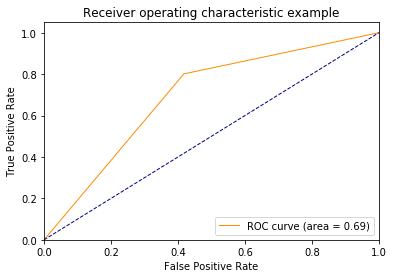

In [132]:
from sklearn.metrics import roc_curve, auc

predicted = clf.predict(corrupted_X_test)
# predicted_proba = clf.predict_proba(corrupted_X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = np.unique(y).shape[0]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predicted)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 1

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# import scikitplot as skplt

# skplt.metrics.plot_roc_curve(y_test, predicted_proba)
# plt.show()

### Fit a simple regression model to the generated training data

In [141]:
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import entropy

regressor_X_train = []
regressor_y_train = []
row_fraction = .6

values_to_change = np.sum(test_mask)
print(values_to_change)
factor = int(round((1. - row_fraction) * values_to_change))

dataset_size_for_regressor = 100

def quant25(x): return np.percentile(x, 25)

def quant50(x): return np.percentile(x, 50)

def quant75(x): return np.percentile(x, 75)

def stats(data):
    funcs = [np.min, np.max, np.mean, np.std, quant25, quant50, quant75]
    for column in data.T:
        for foo in funcs:
            yield foo(column)
    

def create_dataset_for_regressor(clf, X, y, size, mask):
    regressor_X, regressor_y = [], []
    for i in np.random.random_integers(1, 1000, size):
        np.random.seed(i)
        corrupted_data = deepcopy(X)
        new_mask = deepcopy(mask)
        new_mask.loc[np.random.choice(mask[mask == True].index, factor, replace=False)] = False
        corrupted_data['cholesterol'][new_mask] = 3
        regressor_X.append(list(stats(clf.predict_proba(corrupted_data))))
        regressor_y.append(accuracy_score(y, clf.predict(corrupted_data)))
    np.random.seed(1)
    return regressor_X, regressor_y

regressor_X_train, regressor_y_train = create_dataset_for_regressor(clf, X_test, y_test, 100, test_mask)

meta_regressor = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', LinearRegression())
])

meta_regressor.fit(np.array(regressor_X_train), np.array(regressor_y_train).reshape(-1, 1))

2986
7000/7000 [==============================] - 0s 3us/step


7000/7000 [==============================] - 0s 2us/step


Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('learner', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Evaluate regression model in predicting effects of errors in the unseen target data

In [142]:
regressor_X_target, regressor_y_target = create_dataset_for_regressor(clf, X_target, y_target, 100, target_mask)

7000/7000 [==============================] - 0s 1us/step


7000/7000 [==============================] - 0s 3us/step


In [143]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

predicted_target = meta_regressor.predict(regressor_X_target)

score_on_corrupted_target_data = MAE(regressor_y_target, predicted_target)

print("score on corrupted target data: ", score_on_corrupted_target_data)

score on corrupted target data:  0.007999610888861561


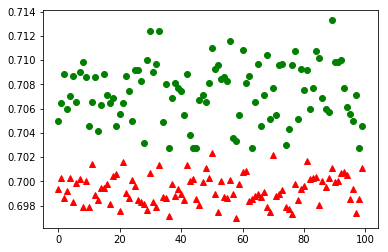

In [144]:
plt.plot(range(len(regressor_y_target)), regressor_y_target, 'go')
plt.plot(range(len(predicted_target)), predicted_target, 'r^')
plt.show()